<table align="left">
    <td align="left"><a target = "_blank" href = "https://www.kaggle.com/code/bernando/dog-breed-classification/edit">
        <img src = "https://tse1.mm.bing.net/th/id/OIP.t024X5xRG-lNrS_ZbFmk9wHaDX?w=316&h=159&c=7&r=0&o=7&dpr=1.5&pid=1.7&rm=3", width = 150/> Run in kaggle notebook</a></td>
    <td align="left"><a target = "_blank" href=  "https://www.linkedin.com/in/bernando-gunawan-45790024b/">
        <img src = "https://www.bing.com/th/id/OIP.6uTQ7mOjYOD2sNKxUdnaNAHaHa?w=189&h=211&c=8&rs=1&qlt=90&o=6&dpr=1.5&pid=3.1&rm=2", width = 70/> Visit my linkedin</a></td>
    <td align="left"><a target="_blank" href="https://github.com/bernandogunawan/Dog_breed_classification">
        <img src="https://www.bing.com/th/id/OIP.fqZ9-PPqcG_cm0k3JfoINQHaEK?w=263&h=211&c=8&rs=1&qlt=90&o=6&dpr=1.5&pid=3.1&rm=2", width = 100  />View Source on GitHub</a></td>
</table>

# Dog Breed Classification

**Predict dog breed from images using deep learning**

**Author:** Bernando Virto Gunawan  
**Dataset:** [Standford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)  
**Objective:** Build and evaluate models to classify dog images into 120 breed classes

The dataset used is from standford dogs dataset. It contains 120 dog breeds and 20,580 images of dogs.

## Project Overview

* This is a multi-class image classification task
* There are 120 dog breeds and 20,580 dog images
* The goal is to train a model to classify each dog image into one of 120 classes
* The metric used is accuracy. It calculates the percentage of correct predictions made by the model

## Environment setup and import

In [1]:
# importing the libraries
from scipy.io import loadmat
import tarfile
import pandas as pd
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torchinfo import summary
import torchvision

## Checking GPU

In [2]:
# checking for GPU
!nvidia-smi

Sun Dec 28 16:02:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load Dataset

from [Standford dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/), we will only focus on the images and the lists folder.

**images** contains images of 120 dog breeds  
**lists** contains a .mat file that has the file name and its labels


In this section, we will:
* set up a path to the files
* load the .mat file and turn it into a dataframe

In [4]:
# Setting up a path
path = "/kaggle/input/dog-breed-classifiation"
images_path = path + "/images/Images/"
lists_path = path + "/lists/"

In [5]:
# Load the .mat file
all_file = loadmat(lists_path + "file_list.mat")
train_file = loadmat(lists_path + "train_list.mat")
test_file = loadmat(lists_path + "test_list.mat")
print(train_file.keys())

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])


In [6]:
# Set dataframe from the loaded matfile
df_train = pd.DataFrame(data = {
    "file_list": [x[0] for x in train_file["file_list"].squeeze()],
    "labels": train_file["labels"].squeeze()
})
df_test = pd.DataFrame(data = {
    "file_list": [x[0] for x in test_file["file_list"].squeeze()],
    "labels": test_file["labels"].squeeze()
})
df_all = pd.DataFrame(data = {
    "file_list": [x[0] for x in all_file["file_list"].squeeze()],
    "labels": all_file["labels"].squeeze()
})
# reduce the label by 1
df_train["labels"] = df_train["labels"] - 1
df_test["labels"] = df_test["labels"] - 1
df_all["labels"] = df_all["labels"]-1

In [7]:
df_train.head()

file_list  labels
0   n02085620-Chihuahua/n02085620_5927.jpg       0
1   n02085620-Chihuahua/n02085620_4441.jpg       0
2   n02085620-Chihuahua/n02085620_1502.jpg       0
3   n02085620-Chihuahua/n02085620_1916.jpg       0
4  n02085620-Chihuahua/n02085620_13151.jpg       0

In [8]:
df_test.head()

file_list  labels
0  n02085620-Chihuahua/n02085620_2650.jpg       0
1  n02085620-Chihuahua/n02085620_4919.jpg       0
2  n02085620-Chihuahua/n02085620_1765.jpg       0
3  n02085620-Chihuahua/n02085620_3006.jpg       0
4  n02085620-Chihuahua/n02085620_1492.jpg       0

In [9]:
df_all.head()

file_list  labels
0  n02085620-Chihuahua/n02085620_10074.jpg       0
1  n02085620-Chihuahua/n02085620_10131.jpg       0
2  n02085620-Chihuahua/n02085620_10621.jpg       0
3   n02085620-Chihuahua/n02085620_1073.jpg       0
4  n02085620-Chihuahua/n02085620_10976.jpg       0

In [10]:
# getting class breed
class_breed = {}
for i in range(df_train["labels"].nunique()):
  temp = df_train[df_train["labels"] == i]
  class_breed[i] = temp["file_list"].iloc[0].split("-",1)[1].split("/",1)[0]
class_breed

{0: 'Chihuahua',
 1: 'Japanese_spaniel',
 2: 'Maltese_dog',
 3: 'Pekinese',
 4: 'Shih-Tzu',
 5: 'Blenheim_spaniel',
 6: 'papillon',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound',
 10: 'basset',
 11: 'beagle',
 12: 'bloodhound',
 13: 'bluetick',
 14: 'black-and-tan_coonhound',
 15: 'Walker_hound',
 16: 'English_foxhound',
 17: 'redbone',
 18: 'borzoi',
 19: 'Irish_wolfhound',
 20: 'Italian_greyhound',
 21: 'whippet',
 22: 'Ibizan_hound',
 23: 'Norwegian_elkhound',
 24: 'otterhound',
 25: 'Saluki',
 26: 'Scottish_deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_bullterrier',
 29: 'American_Staffordshire_terrier',
 30: 'Bedlington_terrier',
 31: 'Border_terrier',
 32: 'Kerry_blue_terrier',
 33: 'Irish_terrier',
 34: 'Norfolk_terrier',
 35: 'Norwich_terrier',
 36: 'Yorkshire_terrier',
 37: 'wire-haired_fox_terrier',
 38: 'Lakeland_terrier',
 39: 'Sealyham_terrier',
 40: 'Airedale',
 41: 'cairn',
 42: 'Australian_terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_bull',
 45:

## Exploratory Data Analysis

let's try to visualize and familiarize ourself with the data

In [11]:
# make a function to visualize our data
# shows 9 random images
def visualize(df,pred = None):
  plt.figure(figsize=(10,10))
  for i in range(9):
    random_index = np.random.randint(0,len(df))
    ax = plt.subplot(3,3,i+1)
    path = images_path + df["file_list"][random_index]
    class_label = df["labels"][random_index]
    class_name = class_breed[class_label]
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n class label: {class_label}\n image shape: {img.shape}")
    plt.axis("off")

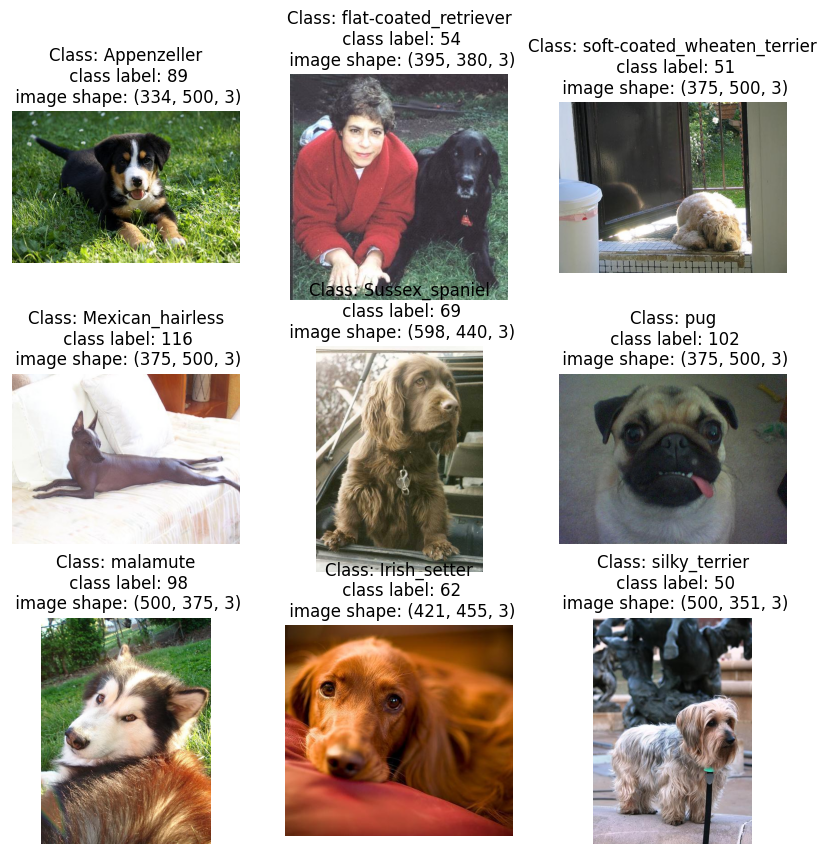

In [12]:
visualize(df_train)

In [13]:
len(df_train)

12000

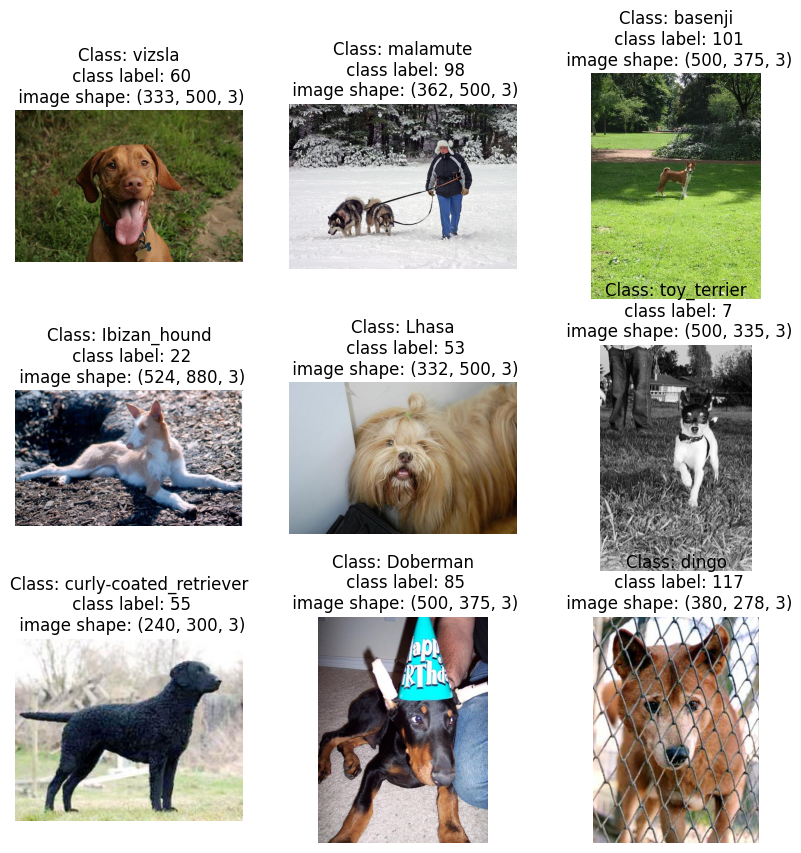

In [14]:
visualize(df_test)

In [15]:
len(df_test)

8580

These images have different sizes and shapes. Before we can use them, we will filter these images based on the size that we use to train our model

In [16]:
IMG_SIZE = 224

In [17]:
# a function to filter our images that are bigger than a certain size
def df_size_filter(df,weight,height):
  temp = []
  for i in range(len(df)):
    path = images_path + df["file_list"][i]
    img = mpimg.imread(path)
    if img.shape[0] >= weight and img.shape[1] >= height:
      temp.append(i)
  return df.iloc[temp]

In [18]:
len(df_train), len(df_test)

(12000, 8580)

In [19]:
# filtering
df_train_filtered = df_size_filter(df_train,IMG_SIZE, IMG_SIZE)
df_test_filtered = df_size_filter(df_test,IMG_SIZE, IMG_SIZE)
df_train_filtered.reset_index(drop=True, inplace=True)
df_test_filtered.reset_index(drop=True, inplace=True)

In [20]:
df_train_filtered.head()

file_list  labels
0   n02085620-Chihuahua/n02085620_5927.jpg       0
1   n02085620-Chihuahua/n02085620_4441.jpg       0
2   n02085620-Chihuahua/n02085620_1502.jpg       0
3   n02085620-Chihuahua/n02085620_1916.jpg       0
4  n02085620-Chihuahua/n02085620_13151.jpg       0

In [21]:
df_test_filtered.head()

file_list  labels
0  n02085620-Chihuahua/n02085620_2650.jpg       0
1  n02085620-Chihuahua/n02085620_1765.jpg       0
2  n02085620-Chihuahua/n02085620_3006.jpg       0
3  n02085620-Chihuahua/n02085620_1492.jpg       0
4  n02085620-Chihuahua/n02085620_2517.jpg       0

In [22]:
print("after filtering")
print(f"total training images: {len(df_train_filtered)}")
print(f"total test images: {len(df_test_filtered)}")

after filtering
total training images: 11066
total test images: 7937


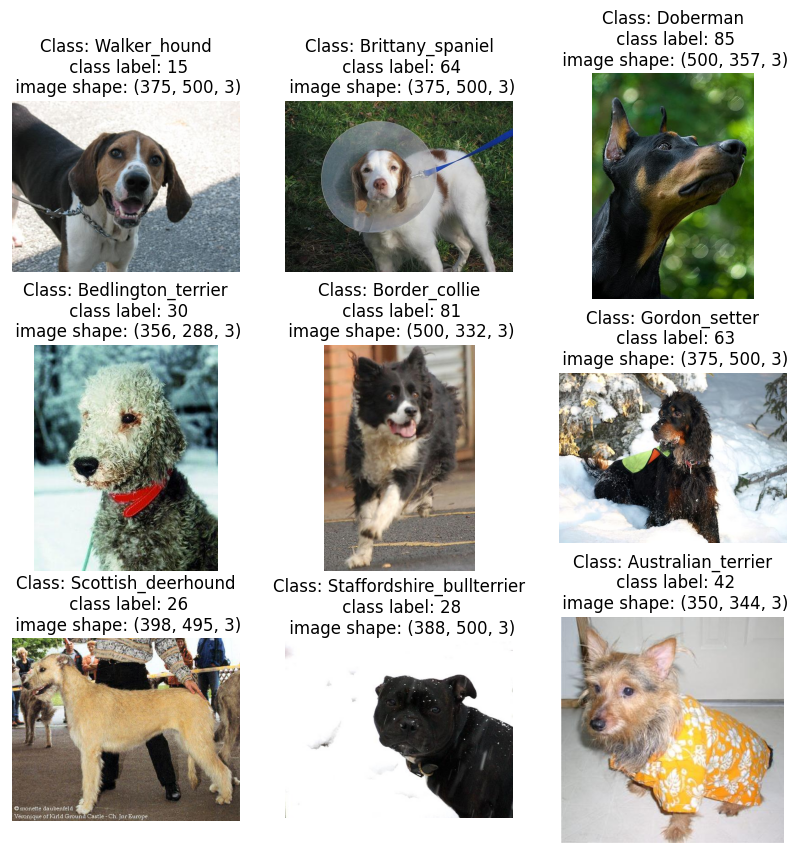

In [23]:
visualize(df_train_filtered)

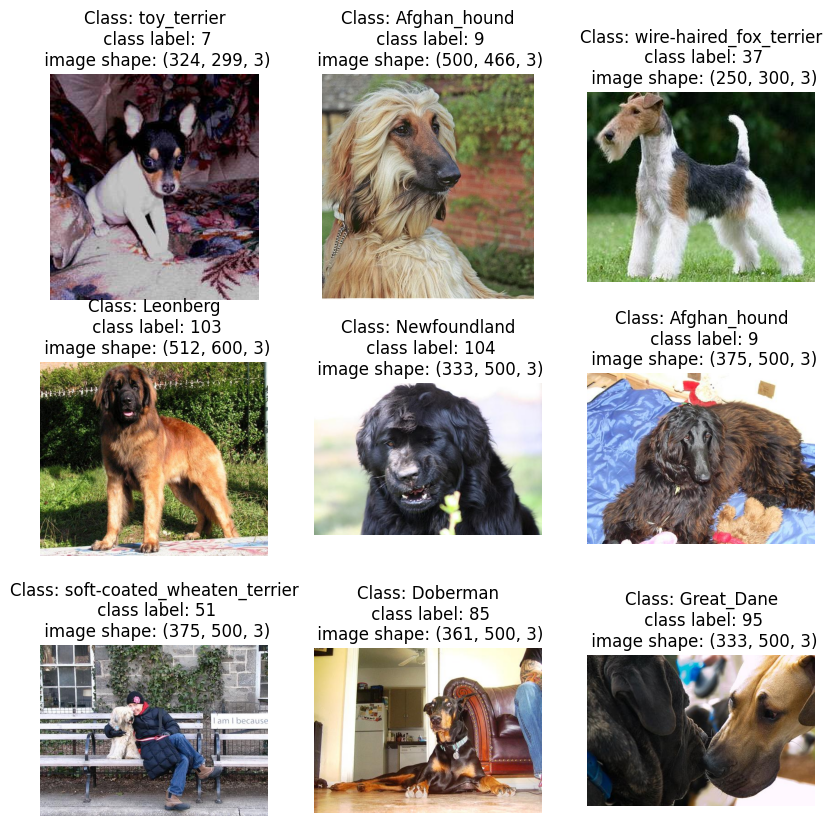

In [24]:
visualize(df_test_filtered)

## Data Preprocessing

In this section, we will preprocess our data to be used by our model.
Therefore, we need to:
* transform our data to `Dataset` type
* Create `Dataloader` to feed the data to our model

In [25]:
# a class to create Dataset object
class CostumDataset(Dataset):
    def __init__(self, image_path, image_file, image_label, transform = None):
        self.image_path = image_path
        self.image_file = image_file
        self.label = image_label
        self.transform = transform

    def __len__(self):
        return len(self.image_file)

    def __getitem__(self,index):
        img_path = os.path.join(self.image_path,self.image_file[index])
        img = mpimg.imread(img_path)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, self.label[index]

    def load_image(self, index):
        img_path = os.path.join(self.image_path,self.image_file[index])
        print(f"label: {self.label[index]}, class: {class_breed[self.label[index]]}")
        return Image.open(img_path)

# preprocessing method for training set
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

# preprocessing method for test set
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [26]:
# creating dataset and dataloader
train_dataset = CostumDataset(image_path = images_path,
                       image_file = df_train_filtered["file_list"], image_label = df_train_filtered["labels"],
                       transform = train_transform)
test_dataset = CostumDataset(image_path = images_path,
                       image_file = df_test_filtered["file_list"], image_label = df_test_filtered["labels"],
                       transform = test_transform)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

label: 0, class: Chihuahua


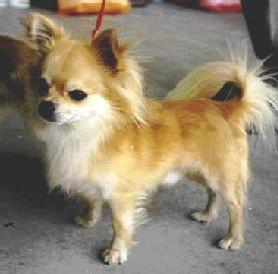

In [27]:
train_dataset.load_image(5)

# Modeling

## Baseline Model

For the baseline model, we are copying the architecture of Tiny VGG from [CNN explainer website](https://poloclub.github.io/cnn-explainer/)

In [28]:
# Create class of model0 based on Tiny VGG
class Model0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
      super().__init__()
      self.conv1_block = nn.Sequential(
          nn.Conv2d(input_shape, hidden_units, kernel_size = 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2)
      )
      self.conv2_block = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
          nn.MaxPool2d(kernel_size = 2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features = hidden_units * 56 * 56,
                   out_features=output_shape)
      )

  def forward(self, x):
      x = self.conv1_block(x)
      x = self.conv2_block(x)
      x = self.classifier(x)
      return x.to(device)

In [29]:
model0 = Model0(input_shape = 3, hidden_units = 10, output_shape = 120).to(device)

In [30]:
summary(model0, input_size = [1,3,IMG_SIZE,IMG_SIZE],
       col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Model0                                   [1, 3, 224, 224]          [1, 120]                  --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 224, 224]         [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 112, 112]         [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         [1, 10, 112, 112]         910
│    └─ReLU: 2-7                

#### Test model0 with 1 image data

predicted index: 83
predicted class: Rottweiler

label: 0, class: Chihuahua


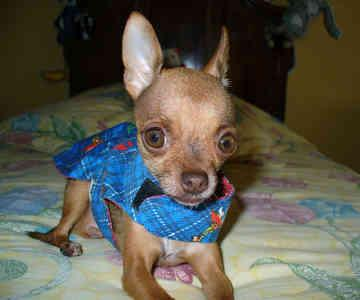

In [31]:
image, label = train_dataloader.dataset[0]
image = image.unsqueeze(dim=0).to(device)


pred = model0(image)

print(f"predicted index: {pred.argmax()}\npredicted class: {class_breed[pred.argmax().item()]}\n")
train_dataloader.dataset.load_image(0)

The prediction process is working; now we only need to train this model

# Train the model

First, let's create a `training step` and `evaluate` functions. We will also later combine these 2 functions for our training loop

In [32]:
# Creating training step function
def train_step(model, dataloader, optimizer, loss_func):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0

    for batch,(images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = loss_func(outputs, labels)

        train_loss = train_loss + loss.item()

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        predicted = torch.argmax(outputs,dim=1)
        
        train_acc += (predicted == labels).sum().item()/len(predicted)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
# creating evaluate function
def evaluate(model, dataloader, loss_func):
    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.inference_mode():
        for batch,(images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            loss = loss_func(outputs, labels)
            
            test_loss = test_loss + loss.item()
            
            predicted = torch.argmax(outputs, dim=1)
            
            test_acc += (predicted == labels).sum().item()/len(predicted)  # Count correct predictions
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
from tqdm.auto import tqdm

# combine train_step and evaluate to this one function
def train(model, train_dataloader, test_dataloader, optimizer, loss_func, epochs):

    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, optimizer, loss_func)

        test_loss, test_acc = evaluate(model, test_dataloader, loss_func)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

Next, we will set the loss function and the optimizer.

Since this is a multi-class classification, we will use the `CrossEntropyLoss` loss function, and we will also use the `Adam` optimizer.

In [35]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(), lr = 0.001)
EPOCHS = 5

In [36]:
# start training
model0_result = train(model0, train_dataloader, test_dataloader, optimizer, loss_func, EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7899 | train_acc: 0.0128 | test_loss: 4.6425 | test_acc: 0.0252
Epoch: 2 | train_loss: 4.6124 | train_acc: 0.0294 | test_loss: 4.6024 | test_acc: 0.0290
Epoch: 3 | train_loss: 4.4209 | train_acc: 0.0534 | test_loss: 4.4080 | test_acc: 0.0506
Epoch: 4 | train_loss: 4.1190 | train_acc: 0.1216 | test_loss: 4.4230 | test_acc: 0.0569
Epoch: 5 | train_loss: 3.3845 | train_acc: 0.3103 | test_loss: 4.8734 | test_acc: 0.0441


The result doesn't look great; it has a test accuracy of 5%.

We will try to use transfer learning next to find a better model for this project.

But first, let's try to plot the loss function for a better understanding. We will create a function to plot it, so we can reuse it again later for different model.

In [37]:
def plot_loss_curve(result):
    train_loss = result["train_loss"]
    test_loss = result["test_loss"]

    train_acc = result["train_acc"]
    test_acc = result["test_acc"]

    epochs = range(len(result["train_loss"]))


    plt.figure(figsize=(15,7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

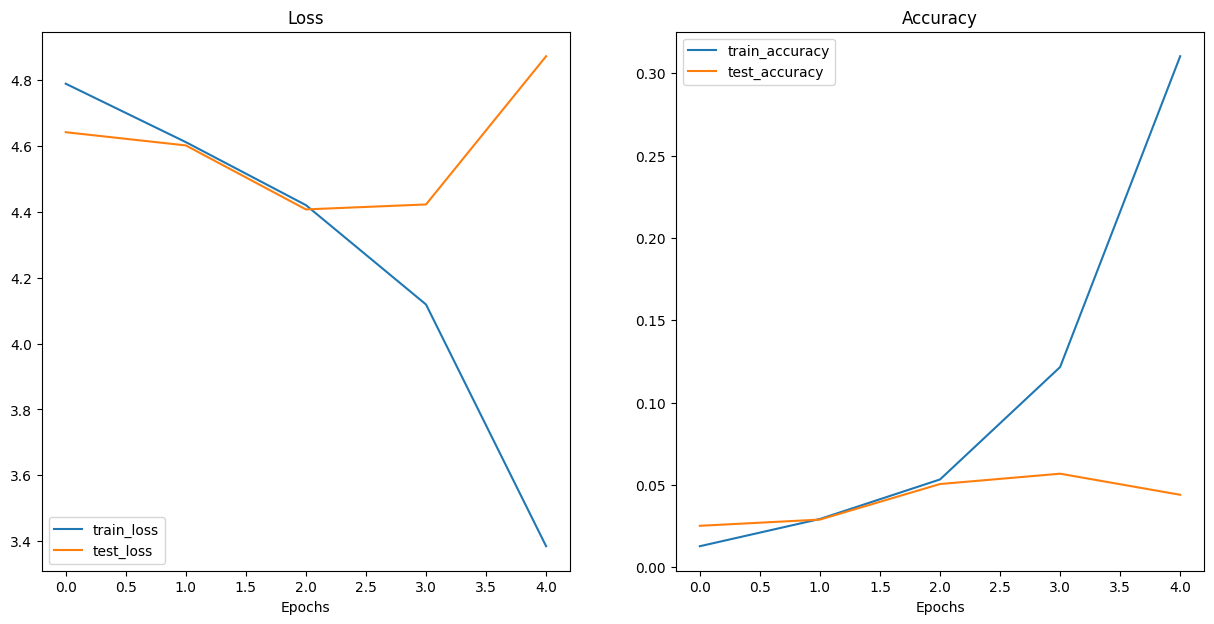

In [38]:
plot_loss_curve(model0_result)

From the plot above, we see that the model already starts to overfit and also performs really badly. This is good enough for our initial model, however, we needs to find a better model to solve our dog breed classification problem. We will do that by using transfer learning.

# Transfer Learning

## EfficientNet

For this section, we will use EfficientNet_B0. We need to prepare the data the same way EfficientNet does it.

In [39]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_tl = torchvision.models.efficientnet_b0(weights = weights).to(device)

# model_tl

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s] 


In [40]:
summary(model_tl,
       input_size = (32,3,224,224),
       col_names = ["input_size", "output_size", "num_params","trainable"],
       col_width = 7)

Layer (type:depth-idx)                                  Input Shape Output Shape Param # Trainable
EfficientNet                                            [32, 3, 224, 224] [32, 1000] --      True
├─Sequential: 1-1                                       [32, 3, 224, 224] [32, 1280, 7, 7] --      True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224] [32, 32, 112, 112] --      True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224] [32, 32, 112, 112] 864     True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112] [32, 32, 112, 112] 64      True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112] [32, 32, 112, 112] --      --
│    └─Sequential: 2-2                                  [32, 32, 112, 112] [32, 16, 112, 112] --      True
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112] [32, 16, 112, 112] 1,448   True
│    └─Sequential: 2-3                                  [32, 

In [41]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [42]:
train_dataset_efficientnet = CostumDataset(image_path = images_path,
                                          image_file = df_train_filtered["file_list"],
                                          image_label = df_train_filtered["labels"],
                                          transform = weights.transforms())
test_dataset_efficientnet = CostumDataset(image_path = images_path,
                                          image_file = df_test_filtered["file_list"],
                                          image_label = df_test_filtered["labels"],
                                          transform = weights.transforms())

train_dataloader_efficientnet = DataLoader(dataset = train_dataset_efficientnet,
                             batch_size = 32,
                             shuffle = True)

test_dataloader_efficientnet = DataLoader(dataset = test_dataset_efficientnet,
                             batch_size = 32,
                             shuffle = False)

In [43]:
# freeze the trained feature layers
for param in model_tl.features.parameters():
    param.requires_grad = False

In [44]:
model_tl.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [45]:
# remake classifier layer to have 120 output features instead
model_tl.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace = True),
    torch.nn.Linear(in_features=1280, out_features=120, bias = True)
).to(device)

In [46]:
summary(model_tl,
        input_size = [31,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 7)

Layer (type:depth-idx)                                  Input Shape Output Shape Param # Trainable
EfficientNet                                            [31, 3, 224, 224] [31, 120] --      Partial
├─Sequential: 1-1                                       [31, 3, 224, 224] [31, 1280, 7, 7] --      False
│    └─Conv2dNormActivation: 2-1                        [31, 3, 224, 224] [31, 32, 112, 112] --      False
│    │    └─Conv2d: 3-1                                 [31, 3, 224, 224] [31, 32, 112, 112] (864)   False
│    │    └─BatchNorm2d: 3-2                            [31, 32, 112, 112] [31, 32, 112, 112] (64)    False
│    │    └─SiLU: 3-3                                   [31, 32, 112, 112] [31, 32, 112, 112] --      --
│    └─Sequential: 2-2                                  [31, 32, 112, 112] [31, 16, 112, 112] --      False
│    │    └─MBConv: 3-4                                 [31, 32, 112, 112] [31, 16, 112, 112] (1,448) False
│    └─Sequential: 2-3                               

In [47]:
# remake loss function and optimizer and train the model
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr = 0.001)
model_tl_result = train(model_tl, train_dataloader_efficientnet, test_dataloader_efficientnet, optimizer, loss_func, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7108 | train_acc: 0.4489 | test_loss: 1.4959 | test_acc: 0.6712
Epoch: 2 | train_loss: 1.3615 | train_acc: 0.6964 | test_loss: 1.1775 | test_acc: 0.7032
Epoch: 3 | train_loss: 1.0483 | train_acc: 0.7487 | test_loss: 1.0799 | test_acc: 0.7118
Epoch: 4 | train_loss: 0.8695 | train_acc: 0.7870 | test_loss: 1.0231 | test_acc: 0.7157
Epoch: 5 | train_loss: 0.7572 | train_acc: 0.8158 | test_loss: 0.9809 | test_acc: 0.7208


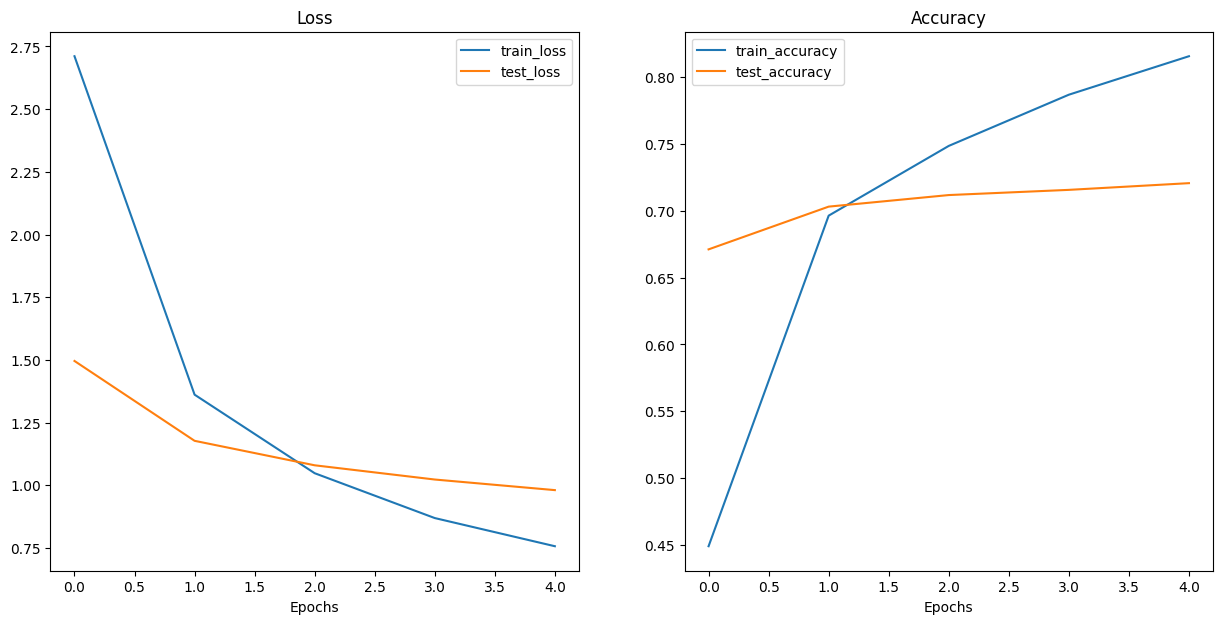

In [48]:
plot_loss_curve(model_tl_result)

The result is better than our baseline model, reaching around 72% accuracy. However, we will still try one more model and compare it to find the best model to use.

## ResNet

For this section, we will use ResNet_50. We need to prepare the data the same way ResNet does it.

In [49]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_resnet = torchvision.models.resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s] 


In [51]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [52]:
train_dataset_resnet = CostumDataset(image_path = images_path,
                                          image_file = df_train_filtered["file_list"],
                                          image_label = df_train_filtered["labels"],
                                          transform = weights.transforms())
test_dataset_resnet = CostumDataset(image_path = images_path,
                                          image_file = df_test_filtered["file_list"],
                                          image_label = df_test_filtered["labels"],
                                          transform = weights.transforms())

train_dataloader_resnet = DataLoader(dataset = train_dataset_resnet,
                             batch_size = 32,
                             shuffle = True)

test_dataloader_resnet = DataLoader(dataset = test_dataset_resnet,
                             batch_size = 32,
                             shuffle = False)

In [53]:
# freeze the feature layers
for param in model_resnet.parameters():
    param.requires_grad = False

In [54]:
model_resnet.fc = nn.Linear(in_features = 2048, out_features = 120, bias=True)

In [55]:
summary(model_resnet,
       input_size = [32,3,224,224],
       col_names = ["input_size","output_size","num_params", "trainable"],
       col_width = 7)

Layer (type:depth-idx)                   Input Shape Output Shape Param # Trainable
ResNet                                   [32, 3, 224, 224] [32, 120] --      Partial
├─Conv2d: 1-1                            [32, 3, 224, 224] [32, 64, 112, 112] (9,408) False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112] [32, 64, 112, 112] (128)   False
├─ReLU: 1-3                              [32, 64, 112, 112] [32, 64, 112, 112] --      --
├─MaxPool2d: 1-4                         [32, 64, 112, 112] [32, 64, 56, 56] --      --
├─Sequential: 1-5                        [32, 64, 56, 56] [32, 256, 56, 56] --      False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56] [32, 256, 56, 56] --      False
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56] [32, 64, 56, 56] (4,096) False
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56] [32, 64, 56, 56] (128)   False
│    │    └─ReLU: 3-3                    [32, 64, 56, 56] [32, 64, 56, 56] --      --
│    │    └─Conv2d: 3-4 

In [56]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr = 0.001)
model_resnet_result = train(model_resnet, train_dataloader_resnet, test_dataloader_resnet, optimizer, loss_func, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1923 | train_acc: 0.6122 | test_loss: 1.0197 | test_acc: 0.8219
Epoch: 2 | train_loss: 0.6455 | train_acc: 0.8755 | test_loss: 0.6645 | test_acc: 0.8527
Epoch: 3 | train_loss: 0.3950 | train_acc: 0.9230 | test_loss: 0.5553 | test_acc: 0.8576
Epoch: 4 | train_loss: 0.2789 | train_acc: 0.9501 | test_loss: 0.4918 | test_acc: 0.8677
Epoch: 5 | train_loss: 0.2076 | train_acc: 0.9639 | test_loss: 0.4942 | test_acc: 0.8622


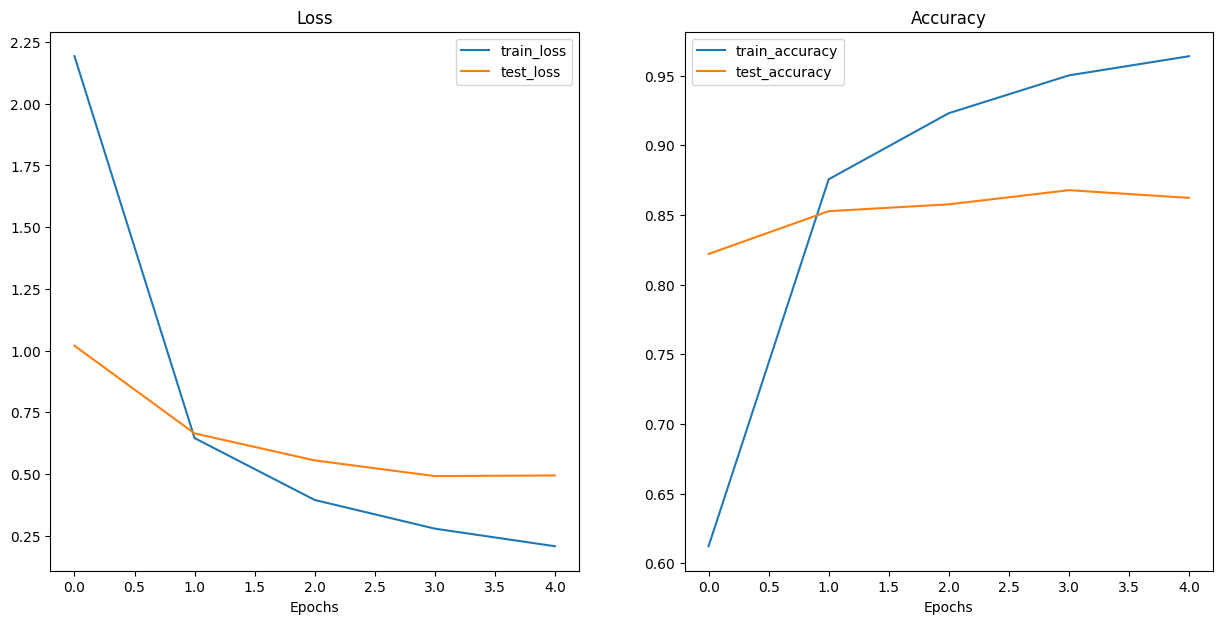

In [57]:
plot_loss_curve(model_resnet_result)

The result from ResNet is currently the best so far, reaching around 86% accuracy

In [62]:
result_model_0 = pd.DataFrame(model0_result)
result_model_0

train_loss  train_acc  test_loss  test_acc
0    4.789922   0.012825   4.642529  0.025226
1    4.612371   0.029353   4.602358  0.028991
2    4.420941   0.053350   4.407951  0.050577
3    4.119015   0.121582   4.423005  0.056852
4    3.384473   0.310277   4.873428  0.044051

In [63]:
result_model_efficientnet = pd.DataFrame(model_tl_result)
result_model_efficientnet

train_loss  train_acc  test_loss  test_acc
0    2.710830   0.448922   1.495861  0.671185
1    1.361518   0.696435   1.177465  0.703188
2    1.048305   0.748652   1.079878  0.711847
3    0.869505   0.786996   1.023145  0.715738
4    0.757227   0.815800   0.980907  0.720758

In [64]:
result_model_resnet = pd.DataFrame(model_resnet_result)
result_model_resnet

train_loss  train_acc  test_loss  test_acc
0    2.192341   0.612161   1.019748  0.821913
1    0.645542   0.875521   0.664500  0.852661
2    0.394968   0.922987   0.555269  0.857555
3    0.278855   0.950103   0.491767  0.867721
4    0.207611   0.963873   0.494214  0.862199

The best model we found in this notebook is the ResNet_50 model. We will experiment more to try find a better model by using comet_ml to track our experiments.
For more info, please check the GitHub.